In [1]:
import zipfile
import datetime
import string
import glob
import math
import os
import json
import lmdb

from imgaug import augmenters as iaa
from imgaug import parameters as iap
import tqdm
import cv2
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import keras
from keras import layers
import sklearn.model_selection

import keras_ocr
from networks.script_identifier.models.script_recog_net import ScriptRecogNet

tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [2]:
model = ScriptRecogNet()

Provided alphabet does not match pretrained alphabet. Using backbone weights only.
Looking for C:\Users\senya\.keras-ocr\crnn_kurapan_notop.h5
Output shape of the encoder:  (None, 50, 256)
Summarizer Input shape:  (None, 50, 256)
After reshape:  (None, 1, 50, 256)


In [3]:
model.model.load_weights("pre-trained-weights/max_sum.h5")

In [4]:
def get_text_generator(alphabet, chance=80):
  while True:
      sentence = ''
      ends = 0
      while not ends:
        alph_type = np.random.rand()
        for key, value in alphabet.items():
          alph_type -= value
          if alph_type <= 0:
            sentence += key[np.random.randint(len(key))]
            break
        if (len(sentence) > chance) or (np.random.randint(chance)//(chance-1) == 1):
          ends = 1
        if (len(sentence) < 5):
          ends = 0
      yield sentence

In [5]:
def get_train_val_test_split(arr):
    train, valtest = sklearn.model_selection.train_test_split(arr, train_size=0.8, random_state=422)
    val, test = sklearn.model_selection.train_test_split(valtest, train_size=0.5, random_state=421)
    return train, val, test

In [6]:
white_path = os.path.join("keras_ocr", "White.png")
backgrounds = keras_ocr.data_generation.get_backgrounds(cache_dir="keras_ocr") + 1000 * [white_path]

Looking for keras_ocr\backgrounds.zip


In [7]:
special_characters = 'áàâãäăāåąæéèêëěēėęíìîïīįıóòôõöőøœúùûüűūůýćčçðđďģğķłļńñňņřśšşßťżźž$€£¥+'
special_characters_upper = 'áàâãäăāåąæéèêëěēėęíìîïīįóòôõöőøœúùûüűūůýćčçðďģğķłļńñňņřśšşťżźž'.upper()
marks = '!?.,-'
letters_lower = ''.join(set(string.ascii_letters.lower()))
letters_upper = ''.join(set(string.ascii_letters.upper()))
latin_alphabet = "".join(set(string.digits + special_characters + special_characters_upper + marks + letters_lower + letters_upper))
latin = {string.digits: 0.08, letters_lower: 0.78, letters_upper: 0.064, marks: 0.03, special_characters: 0.04, special_characters_upper: 0.006}

fonts = keras_ocr.data_generation.get_fonts(
    alphabet=latin_alphabet,
    cache_dir="keras_ocr"
)

Looking for keras_ocr\fonts.zip


Filtering fonts.: 100%|████████████████████████████████████████████████████████████| 2746/2746 [00:35<00:00, 76.79it/s]


The first generated text is: uia!yaxr4kfi1
The first generated validation image (below) contains: kjq5g4fufcl
73f


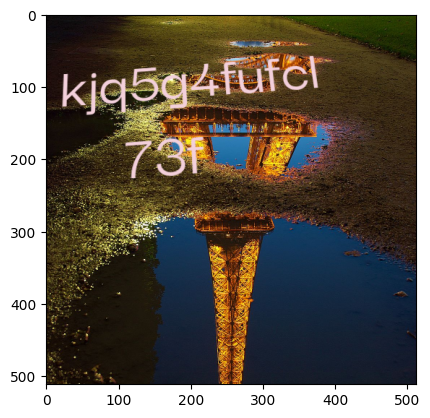

In [8]:
text_generator = get_text_generator(alphabet=latin)
print('The first generated text is:', next(text_generator))

font_splits = get_train_val_test_split(np.repeat(fonts,1000))
background_splits = get_train_val_test_split(np.repeat(backgrounds,20))

latin_image_generators = [
    keras_ocr.data_generation.get_image_generator(
        height=512,
        width=512,
        text_generator=text_generator,
        font_groups={
            latin_alphabet: current_fonts
        },
        backgrounds=current_backgrounds,
        font_size=(24, 120),
        margin=20,
        rotationX=(-0.05, 0.05),
        rotationY=(-0.05, 0.05),
        rotationZ=(-15, 15)
    ) for current_fonts, current_backgrounds in zip(
            font_splits,
            background_splits
      )
]

# See what the first validation image looks like.
image, lines = next(latin_image_generators[0])
text = keras_ocr.data_generation.convert_lines_to_paragraph(lines)
print('The first generated validation image (below) contains:', text)
plt.imshow(image)

In [9]:
special_characters = 'ѓђёsjљњќћџъ$€£¥+'
special_characters_upper = 'ѓђёsjљњќћџъ'.upper()
marks = '!?.,-'
letters_lower = 'абвгґдєежзiїийклмнопрстуўфхцчшщьыэюя'
letters_upper = letters_lower.upper()
cyrillic_alphabet = "".join(set(string.digits + special_characters + special_characters_upper + marks + letters_lower + letters_upper))
cyrillic = {string.digits: 0.08, letters_lower: 0.80, letters_upper: 0.067, marks: 0.03, special_characters: 0.02, special_characters_upper: 0.003}

fonts = keras_ocr.data_generation.get_fonts(
    alphabet=cyrillic_alphabet,
    cache_dir="keras_ocr"
)

Looking for keras_ocr\fonts.zip


Filtering fonts.: 100%|███████████████████████████████████████████████████████████| 2746/2746 [00:09<00:00, 284.27it/s]


The first generated text is: ы.вюХвуњюэекнмквХпрўтяцiзРц62ґгаќ2яыэ-шэзае
The first generated validation image (below) contains: i
г5!йжs
яж2хпд


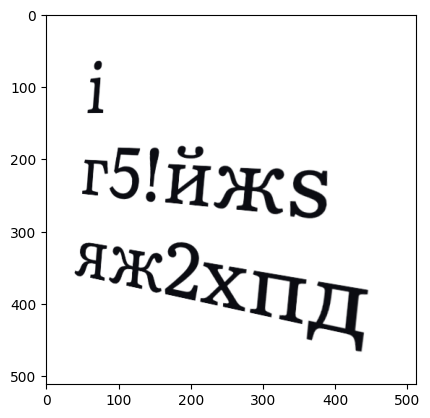

In [10]:
text_generator = get_text_generator(alphabet=cyrillic)
print('The first generated text is:', next(text_generator))

font_splits = get_train_val_test_split(np.repeat(fonts,1000))
background_splits = get_train_val_test_split(np.repeat(backgrounds,20))

cyrillic_image_generators = [
    keras_ocr.data_generation.get_image_generator(
        height=512,
        width=512,
        text_generator=text_generator,
        font_groups={
            cyrillic_alphabet: current_fonts
        },
        backgrounds=current_backgrounds,
        font_size=(24, 120),
        margin=20,
        rotationX=(-0.05, 0.05),
        rotationY=(-0.05, 0.05),
        rotationZ=(-15, 15)
    ) for current_fonts, current_backgrounds in zip(
            font_splits,
            background_splits
      )
]

# See what the first validation image looks like.
image, lines = next(cyrillic_image_generators[0])
text = keras_ocr.data_generation.convert_lines_to_paragraph(lines)
print('The first generated validation image (below) contains:', text)
plt.imshow(image)

In [11]:
special_characters = '$€£¥+'
marks = '!?.,-'
letters_lower = 'اأإآبتثجحخدذرزسشصضطظعغفقكلمنهوىيءئؤة'
arabic_alphabet = "".join(set(string.digits + special_characters + marks + letters_lower))
arabic = {string.digits: 0.08, letters_lower: 0.89, marks: 0.02, special_characters: 0.01}

fonts = keras_ocr.data_generation.get_fonts(
    alphabet=arabic_alphabet,
    cache_dir="keras_ocr"
)

Looking for keras_ocr\fonts.zip


Filtering fonts.: 100%|███████████████████████████████████████████████████████████| 2746/2746 [00:07<00:00, 370.48it/s]


The first generated text is: آبنت8ثهدض5ثثزةظف2ششقتقءرو7أؤإوؤ4آص7بؤ
The first generated validation image (below) contains: أ
ق


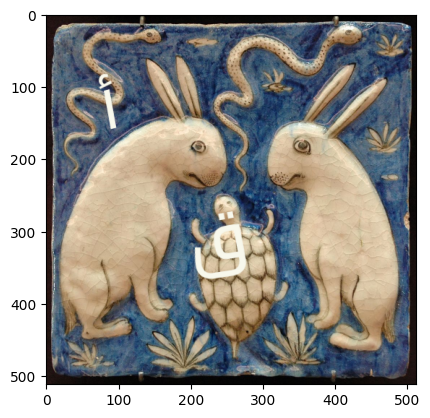

In [12]:
text_generator = get_text_generator(alphabet=arabic)
print('The first generated text is:', next(text_generator))

font_splits = get_train_val_test_split(np.repeat(fonts,1000))
background_splits = get_train_val_test_split(np.repeat(backgrounds,20))

arabic_image_generators = [
    keras_ocr.data_generation.get_image_generator(
        height=512,
        width=512,
        text_generator=text_generator,
        font_groups={
            arabic_alphabet: current_fonts
        },
        backgrounds=current_backgrounds,
        font_size=(24, 120),
        margin=20,
        rotationX=(-0.05, 0.05),
        rotationY=(-0.05, 0.05),
        rotationZ=(-15, 15)
    ) for current_fonts, current_backgrounds in zip(
            font_splits,
            background_splits
      )
]

# See what the first validation image looks like.
image, lines = next(arabic_image_generators[0])
text = keras_ocr.data_generation.convert_lines_to_paragraph(lines)
print('The first generated validation image (below) contains:', text)
plt.imshow(image)

In [13]:
special_characters = '$€£¥+'
marks = '।!?,-'
letters_lower = 'হথশ৫কওয০গদড়খয়ঋনঅ৪এবঠঢ৭৯ধঙটঝৎণতর২চঌড৬ঔপভমঢ়ঈ৮ঘ১ষ৩ফছলজআঃ'
bengali_alphabet = "".join(set(string.digits + special_characters + marks + letters_lower))
bengali = {string.digits: 0.08, letters_lower: 0.89, marks: 0.02, special_characters: 0.01}

fonts = keras_ocr.data_generation.get_fonts(
    alphabet=bengali_alphabet,
    cache_dir="keras_ocr"
)

Looking for keras_ocr\fonts.zip


Filtering fonts.: 100%|███████████████████████████████████████████████████████████| 2746/2746 [00:06<00:00, 397.86it/s]


The first generated text is: অথঌঌঠঃৎ৭চদছযয়ঢ়ফআঢ়ঔশভৎ০অহ10আথঃহ
The first generated validation image (below) contains: ঔআড়9ন
৪
ব৪ঃদ
ফড
আগভ
€ণঠয
2ৎখ
-ণঢ়এ
দ
3ঠয়৪
4ঋপ
ঢ়ব
ফ৫


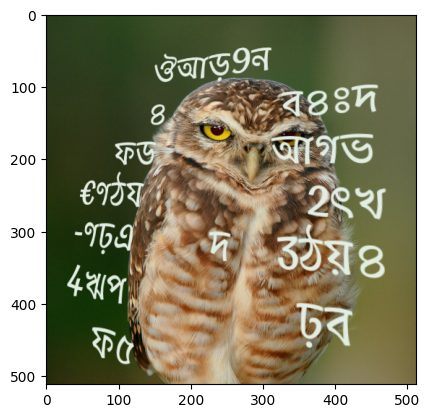

In [14]:
text_generator = get_text_generator(alphabet=bengali)
print('The first generated text is:', next(text_generator))

font_splits = get_train_val_test_split(np.repeat(fonts,1000))
background_splits = get_train_val_test_split(np.repeat(backgrounds,20))

bengali_image_generators = [
    keras_ocr.data_generation.get_image_generator(
        height=512,
        width=512,
        text_generator=text_generator,
        font_groups={
            bengali_alphabet: current_fonts
        },
        backgrounds=current_backgrounds,
        font_size=(24, 120),
        margin=20,
        rotationX=(-0.05, 0.05),
        rotationY=(-0.05, 0.05),
        rotationZ=(-15, 15)
    ) for current_fonts, current_backgrounds in zip(
            font_splits,
            background_splits
      )
]

# See what the first validation image looks like.
image, lines = next(bengali_image_generators[0])
text = keras_ocr.data_generation.convert_lines_to_paragraph(lines)
print('The first generated validation image (below) contains:', text)
plt.imshow(image)

In [15]:
special_characters = '$€£¥+'
marks = '!?,-;:'
letters_lower = '一丁七万丈三上下不与丐丑专且丕世丘丙业丛东丝丞丢两严丧个丫中丰串临丸丹为主丽举乃久么义之乌乍乎乏乐乒乓乔乖乘乙乜九乞也习乡书乩买乱乳乾了予争事二亍于亏云互亓五井亘亚些亟亡亢交亥亦产亨亩享京亭亮亲亳亵人亿什仁仂仃仄仅仆仇仉今介仍从仑仓仔仕他仗付仙仞仟仡代令以仨仪仫们仰仲仳仵件价任份仿企伉伊伍伎伏伐休众优伙会伛伞伟传伢伤伦伧伪伫伯估伴伶伸伺似伽佃但位低住佐佑体何佗佘余佚佛作佝佞佟你佣佤佥佩佬佯佰佳佴佶佻佼佾使侃侄侈侉例侍侏侑侔侗供依侠侣侥侦侧侨侩侪侬侮侯侵便促俄俅俊俎俏俐俑俗俘俚俜保俞俟信俣俦俨俩俪俭修俯俱俳俸俺俾倌倍倏倒倔倘候倚倜借倡倥倦倨倩倪倬倭债值倾偃假偈偌偎偏偕做停健偬偶偷偻偾偿傀傅傈傍傣傥傧储傩催傲傻像僖僚僦僧僬僭僮僳僵僻儆儇儋儒儡儿兀允元兄充兆先光克免兑兔兕兖党兜兢入全八公六兮兰共关兴兵其具典兹养兼兽冀冁内冈冉册再冒冕冗写军农冠冢冤冥冬冯冰冱冲决况冶冷冻冼冽净凄准凇凉凋凌减凑凛凝几凡凤凫凭凯凰凳凶凸凹出击凼函凿刀刁刃分切刈刊刍刎刑划刖列刘则刚创初删判刨利别刭刮到刳制刷券刹刺刻刽刿剀剁剂剃削剌前剐剑剔剖剜剞剡剥剧剩剪副割剽剿劁劂劈劐劓力劝办功加务劢劣动助努劫劬劭励劲劳劾势勃勇勉勋勐勒勖勘募勤勰勺勾勿匀包匆匈匍匏匐匕化北匙匝匠匡匣匦匪匮匹区医匾匿十千卅升午卉半华协卑卒卓单卖南博卜卞卟占卡卢卣卤卦卧卫卮卯印危即却卵卷卸卺卿厂厄厅历厉压厌厍厕厘厚厝原厢厣厥厦厨厩厮去县叁参又叉及友双反发叔取受变叙叛叟叠口古句另叨叩只叫召叭叮可台叱史右叵叶号司叹叻叼叽吁吃各吆合吉吊同名后吏吐向吒吓吕吗君吝吞吟吠吡吣否吧吨吩含听吭吮启吱吲吴吵吸吹吻吼吾呀呃呆呈告呋呐呓呔呕呖呗员呙呛呜呢呤呦周呱呲味呵呶呷呸呻呼命咀咂咄咆咋和咎咏咐咒咔咕咖咙咚咛咝咣咤咦咧咨咩咪咫咬咭咯咱咳咴咸咻咽咿哀品哂哄哆哇哈哉哌响哎哏哐哑哓哔哕哗哙哚哝哞哟哥哦哧哨哩哪哭哮哲哳哺哼哽哿唁唆唇唉唏唐唑唔唛唠唢唣唤唧唪唬售唯唱唳唷唼唾唿啁啃啄商啉啊啐啕啖啜啡啤啥啦啧啪啬啭啮啵啶啷啸啻啼啾喀喁喂喃善喇喈喉喊喋喏喑喔喘喙喜喝喟喧喱喳喵喷喹喻喽喾嗄嗅嗉嗌嗍嗑嗒嗓嗔嗖嗜嗝嗟嗡嗣嗤嗥嗦嗨嗪嗫嗬嗯嗲嗳嗵嗷嗽嗾嘀嘁嘈嘉嘌嘎嘏嘘嘛嘞嘟嘣嘤嘧嘬嘭嘱嘲嘴嘶嘹嘻嘿噌噍噎噔噗噙噜噢噤器噩噪噫噬噱噶噻噼嚅嚆嚎嚏嚓嚣嚯嚷嚼囊囔囚四囝回囟因囡团囤囫园困囱围囵囹固国图囿圃圄圆圈圉圊圜土圣在圩圪圬圭圮圯地圳圹场圻圾址坂均坊坌坍坎坏坐坑块坚坛坜坝坞坟坠坡坤坦坨坩坪坫坭坯坳坷坻坼垂垃垄垅垆型垌垒垓垛垠垡垢垣垤垦垧垩垫垭垮垲垸埂埃埋城埏埒埔埕埘埙埚埝域埠埤埭埯埴埸培基埽堂堆堇堋堍堑堕堙堞堠堡堤堪堰堵塄塌塍塑塔塘塞塥填塬塾墀墁境墅墉墒墓墙增墟墨墩墼壁壅壑壕壤士壬壮声壳壶壹处备复夏夔夕外夙多夜够夤夥大天太夫夭央夯失头夷夸夹夺夼奁奂奄奇奈奉奋奎奏契奔奕奖套奘奚奠奢奥女奴奶奸她好妁如妃妄妆妇妈妊妍妒妓妖妗妙妞妣妤妥妨妩妪妫妮妯妲妹妻妾姆姊始姐姑姒姓委姗姘姚姜姝姣姥姨姬姹姻姿威娃娄娅娆娇娈娉娌娑娓娘娜娟娠娣娥娩娱娲娴娶娼婀婆婉婊婕婚婢婧婪婴婵婶婷婺婿媒媚媛媪媲媳媵媸媾嫁嫂嫉嫌嫒嫔嫖嫘嫜嫠嫡嫣嫦嫩嫫嫱嬉嬖嬗嬴嬷孀子孑孓孔孕字存孙孚孛孜孝孟孢季孤孥学孩孪孬孰孱孳孵孺孽宁它宄宅宇守安宋完宏宓宕宗官宙定宛宜宝实宠审客宣室宥宦宪宫宰害宴宵家宸容宽宾宿寂寄寅密寇富寐寒寓寝寞察寡寤寥寨寮寰寸对寺寻导寿封射将尉尊小少尔尕尖尘尚尜尝尤尥尧尬就尴尸尹尺尻尼尽尾尿局屁层居屈屉届屋屎屏屐屑展屙属屠屡屣履屦屯山屹屺屿岁岂岈岌岍岐岑岔岖岗岘岙岚岛岢岣岩岫岬岭岱岳岵岷岸岿峁峄峋峒峙峡峤峥峦峨峪峭峰峻崂崃崆崇崎崔崖崛崞崤崦崧崩崭崮崴崽嵇嵊嵋嵌嵘嵛嵝嵩嵫嵬嵯嵴嶂嶙嶝嶷巅巍川州巡巢工左巧巨巩巫差巯己已巳巴巷巽巾币市布帅帆师希帏帐帑帔帕帖帘帙帚帛帜帝带帧席帮帱帷常帻帼帽幂幄幅幌幔幕幛幞幡幢干平年并幸幺幻幼幽广庀庄庆庇床庋序庐庑库应底庖店庙庚府庞废庠庥度座庭庳庵庶康庸庹庾廉廊廒廓廖廛廨廪延廷建廿开弁异弃弄弈弊弋式弑弓引弗弘弛弟张弥弦弧弩弭弯弱弹强弼彀归当录彖彗彘彝形彤彦彩彪彬彭彰影彳彷役彻彼往征徂径待徇很徉徊律後徐徒徕得徘徙徜御徨循徭微徵德徼徽心必忆忉忌忍忏忐忑忒忖志忘忙忝忠忡忤忧忪快忭忮忱念忸忻忽忾忿怀态怂怃怄怅怆怊怍怎怏怒怔怕怖怙怛怜思怠怡急怦性怨怩怪怫怯怵总怼怿恁恂恃恋恍恐恒恕恙恚恝恢恣恤恧恨恩恪恫恬恭息恰恳恶恸恹恺恻恼恽恿悃悄悉悌悍悒悔悖悚悛悝悟悠患悦您悫悬悭悯悱悲悴悸悻悼情惆惊惋惑惕惘惚惜惝惟惠惦惧惨惩惫惬惭惮惯惰想惴惶惹惺愀愁愆愈愉愍愎意愕愚感愠愣愤愦愧愫愿慈慊慌慎慑慕慝慢慧慨慰慵慷憋憎憔憝憧憨憩憬憷憾懂懈懊懋懑懒懦懵懿戆戈戊戋戌戍戎戏成我戒戕或戗战戚戛戟戡戢戥截戬戮戳戴户戽戾房所扁扃扇扈扉手扌才扎扑扒打扔托扛扣扦执扩扪扫扬扭扮扯扰扳扶批扼找承技抄抉把抑抒抓投抖抗折抚抛抟抠抡抢护报抨披抬抱抵抹抻押抽抿拂拄担拆拇拈拉拊拌拍拎拐拒拓拔拖拗拘拙拚招拜拟拢拣拥拦拧拨择括拭拮拯拱拳拴拶拷拼拽拾拿持挂指挈按挎挑挖挚挛挝挞挟挠挡挢挣挤挥挨挪挫振挲挹挺挽捂捃捅捆捉捋捌捍捎捏捐捕捞损捡换捣捧捩捭据捱捶捷捺捻掀掂掇授掉掊掌掎掏掐排掖掘掠探掣接控推掩措掬掭掮掰掳掴掷掸掺掼掾揄揆揉揍揎描提插揖揞揠握揣揩揪揭援揶揸揽揿搀搁搂搅搋搌搏搐搓搔搛搜搞搠搡搦搪搬搭搴携搽摁摄摅摆摇摈摊摒摔摘摞摧摩摭摸摹摺撂撄撅撇撑撒撕撖撙撞撤撩撬播撮撰撵撷撸撺撼擀擂擅操擎擐擒擘擞擢擤擦攀攉攒攘攥攫攮支收攸改攻放政故效敉敌敏救敕敖教敛敝敞敢散敦敫敬数敲整敷文斋斌斐斑斓斗料斛斜斟斡斤斥斧斩斫断斯新方於施旁旃旄旅旆旋旌旎族旒旖旗无既日旦旧旨早旬旭旮旯旰旱时旷旺昀昂昃昆昊昌明昏易昔昕昙昝星映春昧昨昭是昱昴昵昶昼显晁晃晋晌晏晒晓晔晕晖晗晚晟晡晤晦晨普景晰晴晶晷智晾暂暄暇暌暑暖暗暝暧暨暮暴暹暾曙曛曜曝曦曩曰曲曳更曷曹曼曾替最月有朊朋服朐朔朕朗望朝期朦木未末本札术朱朴朵机朽杀杂权杆杈杉杌李杏材村杓杖杜杞束杠条来杨杪杭杯杰杲杳杵杷杼松板极构枇枉枋析枕林枘枚果枝枞枢枣枥枧枨枪枫枭枯枰枳枵架枷枸柁柃柄柏某柑柒染柔柘柙柚柜柝柞柠柢查柩柬柯柰柱柳柴柽柿栀栅标栈栉栊栋栌栎栏树栓栖栗栝校栩株栲栳样核根格栽栾桀桁桂桃桄桅框案桉桊桌桎桐桑桓桔桕桠桡桢档桤桥桦桧桨桩桫桴桶桷梁梃梅梆梏梓梗梢梦梧梨梭梯械梳梵检棂棉棋棍棒棕棘棚棠棣森棰棱棵棹棺棼椁椅椋植椎椐椒椟椠椤椭椰椴椹椽椿楂楔楗楚楝楞楠楣楦楫楮楷楸楹楼榀概榄榆榇榈榉榍榔榕榛榜榧榨榫榭榱榴榷榻槁槊槌槎槐槔槛槟槠槭槲槽槿樊樗樘樟模樨横樯樱樵樽樾橄橇橐橘橙橛橡橥橱橹橼檀檄檎檐檑檗檠檩檫檬欠次欢欣欤欧欲欷欺款歃歆歇歉歌歙止正此步武歧歪歹死歼殁殂殃殄殆殇殉殊残殍殒殓殖殚殛殡殪殳殴段殷殿毁毂毅毋母每毒毓比毕毖毗毙毛毡毪毫毯毳毵毹毽氅氆氇氍氏氐民氓气氕氖氘氙氚氛氟氡氢氤氦氧氨氩氪氮氯氰氲水永氽汀汁求汆汇汉汊汐汔汕汗汛汜汝汞江池污汤汨汩汪汰汲汴汶汹汽汾沁沂沃沅沆沈沉沌沏沐沓沔沙沛沟没沣沤沥沦沧沩沪沫沭沮沱河沸油治沼沽沾沿泄泅泉泊泌泐泓泔法泖泗泛泞泠泡波泣泥注泪泫泮泯泰泱泳泵泷泸泺泻泼泽泾洁洄洇洋洌洎洒洗洙洚洛洞津洧洪洫洮洱洲洳洵洹活洼洽派流浃浅浆浇浈浊测浍济浏浑浒浓浔浙浚浜浞浠浣浦浩浪浮浯浴海浸浼涂涅消涉涌涎涑涓涔涕涛涝涞涟涠涡涣涤润涧涨涩涪涫涮涯液涵涸涿淀淄淅淆淇淋淌淑淖淘淙淝淞淠淡淤淦淫淬淮深淳混淹添淼清渊渌渍渎渐渑渔渖渗渚渝渠渡渣渤渥温渫渭港渲渴游渺湃湄湍湎湔湖湘湛湟湫湮湾湿溃溅溆溉溏源溘溜溟溢溥溧溪溯溱溲溴溶溷溺溻溽滁滂滇滋滏滑滓滔滕滗滚滞滟滠满滢滤滥滦滨滩滴滹漂漆漉漏漓演漕漠漤漩漪漫漭漯漱漳漶漾潆潇潋潍潘潜潞潢潦潭潮潲潴潸潺潼澄澈澉澌澍澎澜澡澧澳澶澹激濂濉濑濒濞濠濡濮濯瀑瀚瀛瀣瀵瀹灌灏灞火灭灯灰灵灶灸灼灾灿炀炅炉炊炎炒炔炕炖炙炜炝炫炬炭炮炯炱炳炷炸点炻炼炽烀烁烂烃烈烊烘烙烛烟烤烦烧烨烩烫烬热烯烷烹烽焉焊焐焓焕焖焘焙焚焦焯焰焱然煅煊煌煎煜煞煤煦照煨煮煲煳煸煺煽熄熊熏熔熘熙熟熠熨熬熵熹燃燎燔燕燠燥燧燮燹爆爝爨爪爬爰爱爵父爷爸爹爻爽爿片版牌牍牒牖牙牛牝牟牡牢牦牧物牮牯牲牵特牺牾犀犁犄犊犋犍犏犒犟犬犯犰犴状犷犸犹狁狂狃狄狈狍狎狐狒狗狙狞狠狡狨狩独狭狮狯狰狱狲狳狴狷狸狺狻狼猁猃猊猎猕猖猗猛猜猝猞猡猢猥猩猪猫猬献猱猴猷猸猹猾猿獍獐獒獗獠獬獭獯獾玄率玉王玎玑玖玛玢玩玫玮环现玲玳玷玺玻珀珂珈珉珊珍珏珐珑珙珞珠珥珧珩班珲球琅理琉琏琐琚琛琢琥琦琨琪琬琮琰琳琴琵琶琼瑁瑕瑗瑙瑚瑛瑜瑞瑟瑭瑰瑶瑾璀璁璃璇璋璎璐璜璞璧璨璩瓒瓜瓞瓠瓢瓣瓤瓦瓮瓯瓴瓶瓷瓿甄甏甑甓甘甙甚甜生甥用甩甫甬甭田由甲申电男甸町画甾畀畅畈畋界畎畏畔留畚畛畜略畦番畲畴畸畹畿疃疆疋疏疑疔疖疗疙疚疝疟疠疡疣疤疥疫疬疮疯疰疱疲疳疴疵疸疹疼疽疾痂痃痄病症痈痉痊痍痒痔痕痘痛痞痢痣痤痦痧痨痪痫痰痱痴痹痼痿瘀瘁瘃瘅瘊瘌瘐瘗瘘瘙瘛瘟瘠瘢瘤瘥瘦瘩瘪瘫瘭瘰瘳瘴瘵瘸瘼瘾瘿癀癃癌癍癔癖癜癞癣癫癯癸登白百皂的皆皇皈皋皎皑皓皖皙皤皮皱皲皴皿盂盅盆盈益盍盎盏盐监盒盔盖盗盘盛盟盥目盯盱盲直相盹盼盾省眄眇眈眉看眍眙眚真眠眢眦眨眩眭眯眵眶眷眸眺眼着睁睃睇睐睑睚睛睡睢督睥睦睨睫睬睹睽睾睿瞀瞄瞅瞌瞍瞎瞑瞒瞟瞠瞢瞥瞧瞩瞪瞬瞰瞳瞵瞻瞽瞿矍矗矛矜矢矣知矧矩矫矬短矮石矶矸矽矾矿砀码砂砉砌砍砑砒研砖砗砘砚砜砝砟砣砥砧砭砰破砷砸砹砺砻砼砾础硅硇硌硎硐硒硕硖硗硝硪硫硬硭确硷硼碇碉碌碍碎碑碓碗碘碚碛碜碟碡碣碥碧碰碱碲碳碴碹碾磁磅磉磊磋磐磔磕磙磨磬磲磴磷磺礁礅礓礞礤礴示礻礼社祀祁祆祈祉祓祖祗祚祛祜祝神祟祠祢祥祧票祭祯祷祸祺禀禁禄禅禊福禚禧禳禹禺离禽禾秀私秃秆秉秋种科秒秕秘租秣秤秦秧秩秫秭积称秸移秽稀稂稆程稍税稔稗稚稞稠稣稳稷稻稼稽稿穆穑穗穰穴究穷穸穹空穿窀突窃窄窈窍窑窒窕窖窗窘窜窝窟窠窥窦窨窬窭窳窿立竖站竞竟章竣童竦竭端竹竺竽竿笃笄笆笈笊笋笏笑笔笕笙笛笞笠笤笥符笨笪笫第笮笱笳笸笺笼笾筅筇等筋筌筏筐筑筒答策筘筚筛筝筠筢筮筱筲筵筷筹筻签简箅箍箐箔箕算箜管箢箦箧箨箩箪箫箬箭箱箴箸篁篆篇篌篑篓篙篚篝篡篥篦篪篮篱篷篼篾簇簋簌簏簖簟簦簧簪簸簿籀籁籍米籴类籼籽粉粑粒粕粗粘粜粝粞粟粤粥粪粮粱粲粳粹粼粽精糁糅糇糈糊糌糍糕糖糗糙糜糟糠糨糯系紊素索紧紫累絮絷綦綮縻繁繇纂纛纠纡红纣纤纥约级纨纩纪纫纬纭纯纰纱纲纳纵纶纷纸纹纺纽纾线绀绁绂练组绅细织终绉绊绋绌绍绎经绐绑绒结绔绕绗绘给绚绛络绝绞统绠绡绢绣绥绦继绨绩绪绫续绮绯绰绲绳维绵绶绷绸绺绻综绽绾绿缀缁缂缃缄缅缆缇缈缉缌缎缏缑缒缓缔缕编缗缘缙缚缛缜缝缟缠缡缢缣缤缥缦缧缨缩缪缫缬缭缮缯缰缱缲缳缴缵缶缸缺罂罄罅罐网罔罕罗罘罚罟罡罢罨罩罪置罱署罴罹罾羁羊羌美羔羚羝羞羟羡群羧羯羰羲羸羹羼羽羿翁翅翊翌翎翔翕翘翟翠翡翥翦翩翮翰翱翳翻翼耀老考耄者耆耋而耍耐耒耔耕耖耗耘耙耜耠耢耥耦耧耨耩耪耱耳耵耶耷耸耻耽耿聂聃聆聊聋职聍聒联聘聚聩聪聱聿肃肄肆肇肉肋肌肓肖肘肚肛肝肟肠股肢肤肥肩肪肫肭肮肯肱育肴肷肺肼肽肾肿胀胁胂胃胄胆背胍胎胖胗胙胚胛胜胝胞胡胤胥胧胨胩胪胫胬胭胯胰胱胲胳胴胶胸胺胼能脂脆脉脊脍脎脏脐脑脒脓脔脖脘脚脞脬脯脱脲脶脸脾腆腈腊腋腌腐腑腓腔腕腙腚腠腥腧腩腭腮腰腱腴腹腺腻腼腽腾腿膀膂膈膊膏膑膘膛膜膝膦膨膪膳膺膻臀臁臂臃臆臊臌臣臧自臬臭至致臻臼臾舀舁舂舄舅舆舌舍舐舒舔舛舜舞舟舡舢舣舨航舫般舰舱舳舴舵舶舷舸船舻舾艄艇艋艘艚艟艨艮良艰色艳艴艺艽艾艿节芄芈芊芋芍芎芏芑芒芗芘芙芜芝芟芡芥芦芨芩芪芫芬芭芮芯芰花芳芴芷芸芹芽芾苁苄苇苈苊苋苌苍苎苏苑苒苓苔苕苗苘苛苜苞苟苠苡苣苤若苦苫苯英苴苷苹苻茁茂范茄茅茆茈茉茌茎茏茑茔茕茗茚茛茜茧茨茫茬茭茯茱茳茴茵茶茸茹茼荀荃荆荇草荏荐荑荒荔荚荛荜荞荟荠荡荣荤荥荦荧荨荩荪荫荬荭药荷荸荻荼荽莅莆莉莎莒莓莘莛莜莞莠莨莩莪莫莰莱莲莳莴莶获莸莹莺莼莽菀菁菅菇菊菌菏菔菖菘菜菝菟菠菡菥菩菪菰菱菲菹菽萁萃萄萋萌萍萎萏萑萘萜萝萤营萦萧萨萱萸萼落葆葑著葚葛葜葡董葩葫葬葭葱葳葵葶葸葺蒂蒇蒈蒉蒋蒌蒎蒗蒙蒜蒡蒯蒲蒴蒸蒹蒺蒽蒿蓁蓄蓉蓊蓍蓐蓑蓓蓖蓝蓟蓠蓣蓥蓦蓬蓰蓼蓿蔌蔑蔓蔗蔚蔟蔡蔫蔬蔷蔸蔹蔺蔻蔼蔽蕃蕈蕉蕊蕖蕙蕞蕤蕨蕲蕴蕹蕺蕻蕾薄薅薇薏薛薜薤薨薪薮薯薰薷薹藁藉藏藐藓藕藜藤藩藻藿蘅蘑蘖蘧蘩蘸蘼虎虏虐虑虔虚虞虢虫虬虮虱虹虺虻虼虽虾虿蚀蚁蚂蚊蚋蚌蚍蚓蚕蚜蚝蚣蚤蚧蚨蚩蚬蚯蚰蚱蚴蚶蚺蛀蛄蛆蛇蛉蛊蛋蛎蛏蛐蛑蛔蛘蛙蛛蛞蛟蛤蛩蛭蛮蛰蛱蛲蛳蛴蛸蛹蛾蜀蜂蜃蜇蜈蜉蜊蜍蜒蜓蜕蜗蜘蜚蜜蜞蜡蜢蜣蜥蜩蜮蜱蜴蜷蜻蜾蜿蝇蝈蝉蝌蝎蝓蝗蝙蝠蝣蝤蝥蝮蝰蝴蝶蝻蝼蝽蝾螂螃螅螈螋融螗螟螨螫螬螭螯螳螵螺螽蟀蟆蟊蟋蟑蟒蟛蟠蟥蟪蟮蟹蟾蠃蠊蠓蠕蠖蠡蠢蠲蠹蠼血衄衅行衍衔街衙衡衢衣补表衩衫衬衮衰衲衷衽衾衿袁袂袄袅袈袋袍袒袖袜袢袤被袭袱袼裁裂装裆裉裎裒裔裕裘裙裟裢裣裤裥裨裰裱裳裴裸裹裼裾褂褊褐褒褓褙褚褛褡褥褪褫褰褴褶襁襄襞襟襦襻西要覃覆见观规觅视觇览觉觊觋觌觎觏觐觑角觖觚觜觞解觥触觫觯觳言訇訾詈詹誉誊誓謇警譬计订讣认讥讦讧讨让讪讫训议讯记讲讳讴讵讶讷许讹论讼讽设访诀证诂诃评诅识诈诉诊诋诌词诎诏译诒诓诔试诖诗诘诙诚诛诜话诞诟诠诡询诣诤该详诧诨诩诫诬语诮误诰诱诲诳说诵请诸诹诺读诼诽课诿谀谁谂调谄谅谆谇谈谊谋谌谍谎谏谐谑谒谓谔谕谖谗谙谚谛谜谝谟谠谡谢谣谤谥谦谧谨谩谪谫谬谭谮谯谰谱谲谳谴谵谶谷豁豆豇豉豌豕豚象豢豪豫豳豸豹豺貂貅貉貊貌貔貘贝贞负贡财责贤败账货质贩贪贫贬购贮贯贰贱贲贳贴贵贶贷贸费贺贻贼贽贾贿赀赁赂赃资赅赆赇赈赉赊赋赌赍赎赏赐赓赔赖赘赙赚赛赜赝赞赠赡赢赣赤赦赧赫赭走赳赴赵赶起趁趄超越趋趑趔趟趣趱足趴趵趸趺趼趾趿跃跄跆跋跌跎跏跑跖跗跚跛距跞跟跣跤跨跪跬路跳践跷跸跹跺跻跽踅踉踊踌踏踔踝踞踟踢踣踩踪踬踮踯踱踵踹踺踽蹀蹁蹂蹄蹇蹈蹉蹊蹋蹑蹒蹙蹦蹩蹬蹭蹯蹰蹲蹴蹶蹼蹿躁躅躇躏躐躔躜躞身躬躯躲躺车轧轨轩轫转轭轮软轰轱轲轳轴轵轶轷轸轺轻轼载轾轿辁辂较辄辅辆辇辈辉辊辋辍辎辏辐辑输辔辕辖辗辘辙辚辛辜辞辟辣辨辩辫辰辱边辽达迁迂迄迅过迈迎运近迓返迕还这进远违连迟迢迤迥迦迨迩迪迫迭迮述迷迸迹追退送适逃逄逅逆选逊逋逍透逐逑递途逖逗通逛逝逞速造逡逢逦逭逮逯逵逶逸逻逼逾遁遂遄遇遍遏遐遑遒道遗遘遛遢遣遥遨遭遮遴遵遽避邀邂邃邈邋邑邓邕邗邙邛邝邡邢那邦邪邬邮邯邰邱邳邴邵邶邸邹邺邻邾郁郄郅郇郊郎郏郐郑郓郗郛郜郝郡郢郦郧部郫郭郯郴郸都郾鄂鄄鄙鄞鄢鄣鄯鄱鄹酃酆酉酊酋酌配酎酏酐酒酗酚酝酞酡酢酣酤酥酩酪酬酮酯酰酱酲酴酵酶酷酸酹酽酾酿醅醇醉醋醌醍醐醑醒醚醛醢醪醭醮醯醴醵醺采釉释里重野量金釜鉴銎銮鋈錾鍪鎏鏊鏖鐾鑫钆钇针钉钊钋钌钍钎钏钐钒钓钔钕钗钙钚钛钜钝钞钟钠钡钢钣钤钥钦钧钨钩钪钫钬钭钮钯钰钱钲钳钴钵钷钹钺钻钼钽钾钿铀铁铂铃铄铅铆铈铉铊铋铌铍铎铐铑铒铕铗铘铙铛铜铝铞铟铠铡铢铣铤铥铧铨铩铪铫铬铭铮铯铰铱铲铳铴铵银铷铸铹铺铼铽链铿销锁锂锃锄锅锆锇锈锉锊锋锌锎锏锐锑锒锓锔锕锖锗锘错锚锛锝锞锟锡锢锣锤锥锦锨锩锪锫锬锭键锯锰锱锲锴锵锶锷锸锹锺锻锾锿镀镁镂镄镅镆镇镉镊镌镍镎镏镐镑镒镓镔镖镗镘镛镜镝镞镡镢镣镤镥镦镧镨镩镪镫镬镭镯镰镱镲镳镶长门闩闪闫闭问闯闰闱闲闳间闵闶闷闸闹闺闻闼闽闾阀阁阂阃阄阅阆阈阉阊阋阌阍阎阏阐阑阒阔阕阖阗阙阚阜队阡阢阪阮阱防阳阴阵阶阻阼阽阿陀陂附际陆陇陈陉陋陌降限陔陕陛陟陡院除陧陨险陪陬陲陴陵陶陷隅隆隈隋隍随隐隔隗隘隙障隧隰隳隶隼隽难雀雁雄雅集雇雉雌雍雎雏雒雕雠雨雩雪雯雳零雷雹雾需霁霄霆震霈霉霍霎霏霓霖霜霞霪霭霰露霸霹霾青靓靖静靛非靠靡面靥革靳靴靶靼鞅鞋鞍鞑鞒鞘鞠鞣鞫鞭鞯鞲鞴韦韧韩韪韫韬韭音韵韶页顶顷顸项顺须顼顽顾顿颀颁颂颃预颅领颇颈颉颊颌颍颏颐频颓颔颖颗题颚颛颜额颞颟颠颡颢颤颥颦颧风飑飒飓飕飘飙飚飞食飧飨餍餐餮饔饕饥饧饨饩饪饫饬饭饮饯饰饱饲饴饵饶饷饺饼饽饿馀馁馄馅馆馇馈馊馋馍馏馐馑馒馓馔馕首馗馘香馥馨马驭驮驯驰驱驳驴驵驶驷驸驹驺驻驼驽驾驿骀骁骂骄骅骆骇骈骊骋验骏骐骑骒骓骖骗骘骚骛骜骝骞骟骠骡骢骣骤骥骧骨骰骶骷骸骺骼髀髁髂髅髋髌髑髓高髡髦髫髭髯髹髻鬃鬈鬏鬓鬟鬣鬯鬲鬻鬼魁魂魃魄魅魇魈魉魍魏魑魔鱼鱿鲁鲂鲅鲆鲇鲈鲋鲍鲎鲐鲑鲔鲚鲛鲜鲞鲟鲠鲡鲢鲣鲤鲥鲦鲧鲨鲩鲫鲭鲮鲰鲱鲲鲳鲴鲵鲷鲸鲺鲻鲼鲽鳃鳄鳅鳆鳇鳊鳌鳍鳎鳏鳐鳓鳔鳕鳖鳗鳘鳙鳜鳝鳞鳟鳢鸟鸠鸡鸢鸣鸥鸦鸨鸩鸪鸫鸬鸭鸯鸱鸲鸳鸵鸶鸷鸸鸹鸺鸽鸾鸿鹁鹂鹃鹄鹅鹆鹇鹈鹉鹊鹋鹌鹎鹏鹑鹕鹗鹘鹚鹛鹜鹞鹣鹤鹦鹧鹨鹩鹪鹫鹬鹭鹰鹱鹳鹿麂麇麈麋麒麓麝麟麦麸麻麽麾黄黉黍黎黏黑黔默黛黜黝黟黠黢黥黧黩黯黹黻黼黾鼋鼍鼎鼐鼓鼗鼙鼠鼢鼬鼯鼷鼹鼻鼾齐齑齿龀龃龄龅龆龇龈龉龊龋龌龙龚龛龟龠'
chinese_alphabet = "".join(set(special_characters + marks + letters_lower))
chinese = {letters_lower: 0.95, marks: 0.02, special_characters: 0.01}

fonts = keras_ocr.data_generation.get_fonts(
    alphabet=chinese_alphabet,
    cache_dir="keras_ocr"
)

Looking for keras_ocr\fonts.zip


Filtering fonts.: 100%|███████████████████████████████████████████████████████████| 2746/2746 [00:10<00:00, 264.80it/s]


The first generated text is: 舅响咻鹂硕!矍努搏馀夕
The first generated validation image (below) contains: 灸郊嵝峰轼苍
酡榧晃权磔奄怃绺鼷呋鞍璞


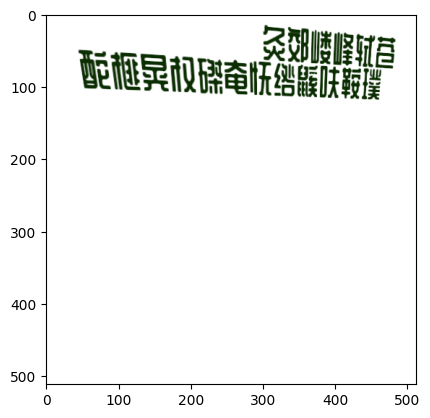

In [16]:
text_generator = get_text_generator(alphabet=chinese)
print('The first generated text is:', next(text_generator))

font_splits = get_train_val_test_split(np.repeat(fonts,1000))
background_splits = get_train_val_test_split(np.repeat(backgrounds,20))

chinese_image_generators = [
    keras_ocr.data_generation.get_image_generator(
        height=512,
        width=512,
        text_generator=text_generator,
        font_groups={
            chinese_alphabet: current_fonts
        },
        backgrounds=current_backgrounds,
        font_size=(24, 120),
        margin=20,
        rotationX=(-0.05, 0.05),
        rotationY=(-0.05, 0.05),
        rotationZ=(-15, 15)
    ) for current_fonts, current_backgrounds in zip(
            font_splits,
            background_splits
      )
]

# See what the first validation image looks like.
image, lines = next(chinese_image_generators[0])
text = keras_ocr.data_generation.convert_lines_to_paragraph(lines)
print('The first generated validation image (below) contains:', text)
plt.imshow(image)

In [17]:
def ident_generator(recognition_image_generators):
    while True:
        generator_num = np.random.randint(len(recognition_image_generators))
        image, lines = next(recognition_image_generators[generator_num])
        if image is not None and image.shape:
            yield image, generator_num%5

In [18]:
max_length = 10
chinese_train_generator, chinese_val_generator, chinese_test_generator = [
        keras_ocr.data_generation.convert_image_generator_to_recognizer_input(
          image_generator=image_generator,
          max_string_length=max_length,
          target_width=200,
          target_height=31,
          margin=1
        ) for image_generator in chinese_image_generators
]
bengali_train_generator, bengali_val_generator, bengali_test_generator = [
        keras_ocr.data_generation.convert_image_generator_to_recognizer_input(
          image_generator=image_generator,
          max_string_length=max_length,
          target_width=200,
          target_height=31,
          margin=1
        ) for image_generator in bengali_image_generators
]
arabic_train_generator, arabic_val_generator, arabic_test_generator = [
        keras_ocr.data_generation.convert_image_generator_to_recognizer_input(
          image_generator=image_generator,
          max_string_length=max_length,
          target_width=200,
          target_height=31,
          margin=1
        ) for image_generator in arabic_image_generators
]
cyrillic_train_generator, cyrillic_val_generator, cyrillic_test_generator = [
        keras_ocr.data_generation.convert_image_generator_to_recognizer_input(
          image_generator=image_generator,
          max_string_length=max_length,
          target_width=200,
          target_height=31,
          margin=1
        ) for image_generator in cyrillic_image_generators
]
latin_train_generator, latin_val_generator, latin_test_generator = [
        keras_ocr.data_generation.convert_image_generator_to_recognizer_input(
          image_generator=image_generator,
          max_string_length=max_length,
          target_width=200,
          target_height=31,
          margin=1
        ) for image_generator in latin_image_generators
]

In [19]:
detector = keras_ocr.detection.Detector(weights='clovaai_general')

Looking for C:\Users\senya\.keras-ocr\craft_mlt_25k.h5


In [20]:
def latin_add_generator(detector):
    for image_path in os.listdir("dataset/lang-detect-dataset/Latin/train"):
        image = keras_ocr.tools.read(os.path.join("dataset/lang-detect-dataset/Latin/train", image_path))
        keras_ocr.tools.resize_image(image, max_scale=2, max_size=2048)
        box_groups = detector.detect(images=[image])
        if (len(box_groups[0])):
            box_num = np.random.randint(len(box_groups[0]))
            crop = keras_ocr.tools.warpBox(
                image=image,
                box=box_groups[0][box_num],
                target_width=200,
                target_height=31,
                margin=3,
                skip_rotate=True,
            )
            yield crop, ""

In [21]:
latin_add_generator_train = latin_add_generator(detector)

In [22]:
def hindi_add_generator(detector):
    for image_path in os.listdir("dataset/lang-detect-dataset/Bengali/train"):
        image = keras_ocr.tools.read(os.path.join("dataset/lang-detect-dataset/Bengali/train", image_path))
        keras_ocr.tools.resize_image(image, max_scale=2, max_size=2048)
        box_groups = detector.detect(images=[image])
        if (len(box_groups[0])):
            box_num = np.random.randint(len(box_groups[0]))
            crop = keras_ocr.tools.warpBox(
                image=image,
                box=box_groups[0][box_num],
                target_width=200,
                target_height=31,
                margin=3,
                skip_rotate=True,
            )
            yield crop, ""

In [23]:
hindi_add_generator_train = hindi_add_generator(detector)

In [24]:
def cyrillic_add_generator(detector):
    for image_path in os.listdir("dataset/lang-detect-dataset/Cyrillic/train"):
        image = keras_ocr.tools.read(os.path.join("dataset/lang-detect-dataset/Cyrillic/train", image_path))
        keras_ocr.tools.resize_image(image, max_scale=2, max_size=2048)
        box_groups = detector.detect(images=[image])
        if (len(box_groups[0])):
            box_num = np.random.randint(len(box_groups[0]))
            crop = keras_ocr.tools.warpBox(
                image=image,
                box=box_groups[0][box_num],
                target_width=200,
                target_height=31,
                margin=3,
                skip_rotate=True,
            )
            yield crop, ""

In [25]:
cyrillic_add_generator_train = cyrillic_add_generator(detector)

In [26]:
def arabic_add_generator(detector):
    for image_path in os.listdir("dataset/lang-detect-dataset/Arabic/train"):
        image = keras_ocr.tools.read(os.path.join("dataset/lang-detect-dataset/Arabic/train", image_path))
        keras_ocr.tools.resize_image(image, max_scale=2, max_size=2048)
        box_groups = detector.detect(images=[image])
        if (len(box_groups[0])):
            box_num = np.random.randint(len(box_groups[0]))
            crop = keras_ocr.tools.warpBox(
                image=image,
                box=box_groups[0][box_num],
                target_width=200,
                target_height=31,
                margin=3,
                skip_rotate=True,
            )
            yield crop, ""

In [27]:
arabic_add_generator_train = arabic_add_generator(detector)

In [28]:
from PIL import Image
import six

def chinese_add_generator(detector):
    env = lmdb.open(
            "dataset/lang-detect-dataset/Chinese/train",
            max_readers=1,
            readonly=True,
            lock=False,
            readahead=False,
            meminit=False)
    with env.begin(write=False) as txn:
        nSamples = int(txn.get('num-samples'.encode()))
        index = 1
        while True:
            img_key = 'image-%09d' % index
            imgbuf = txn.get(img_key.encode())

            buf = six.BytesIO()
            buf.write(imgbuf)
            buf.seek(0)
            try:
                img = Image.open(buf)
                img = img.convert("RGB")
            except IOError:
                print('Corrupted image for %d' % index)
            index = (index + 1) % nSamples
            yield img, ""

In [29]:
chinese_add_generator_train = chinese_add_generator(detector)

In [30]:
identification_train_generator = model.get_batch_generator(
                                 ident_generator([latin_train_generator, 
                                                  cyrillic_train_generator,
                                                  arabic_train_generator,
                                                  bengali_train_generator,
                                                  chinese_train_generator,
                                                  #latin_add_generator_train,
                                                  #cyrillic_add_generator_train,
                                                  #arabic_add_generator_train,
                                                  #hindi_add_generator_train,
                                                  #chinese_add_generator_train
                                                 ]),
                                 4)
identification_val_generator = model.get_batch_generator(
                                 ident_generator([latin_val_generator, 
                                                  cyrillic_val_generator,
                                                  arabic_val_generator,
                                                  bengali_val_generator,
                                                  chinese_val_generator]),
                                 4)

In [35]:
model.compile(loss=tf.keras.losses.CategoricalCrossentropy(), 
              optimizer=tf.keras.optimizers.Adam(learning_rate=tf.keras.optimizers.schedules.ExponentialDecay(
                                                                 0.0001,
                                                                 decay_steps=10000,
                                                                 decay_rate=0.96,
                                                                 staircase=True)), 
              metrics=['accuracy'])

In [36]:
model.model.fit(
    identification_train_generator,
    epochs=1000,
    steps_per_epoch=1000,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(restore_best_weights=True, patience=250),
        tf.keras.callbacks.ModelCheckpoint(filepath='pre-trained-weights/max_sum.h5'),
    ],
    validation_data=identification_val_generator,
    validation_steps=20,
    workers=0,
    batch_size=4
)

Epoch 1/1000
1000/1000 [==============================] - 140s 134ms/step - loss: 0.2569 - accuracy: 0.9020 - val_loss: 0.1496 - val_accuracy: 0.9500
Epoch 2/1000
1000/1000 [==============================] - 135s 135ms/step - loss: 0.2420 - accuracy: 0.9105 - val_loss: 0.3379 - val_accuracy: 0.8500
Epoch 3/1000
1000/1000 [==============================] - 133s 133ms/step - loss: 0.2436 - accuracy: 0.9053 - val_loss: 0.2163 - val_accuracy: 0.9125
Epoch 4/1000
1000/1000 [==============================] - 133s 133ms/step - loss: 0.2543 - accuracy: 0.9082 - val_loss: 0.4472 - val_accuracy: 0.8625
Epoch 5/1000
1000/1000 [==============================] - 138s 138ms/step - loss: 0.2635 - accuracy: 0.8978 - val_loss: 0.2439 - val_accuracy: 0.8875
Epoch 6/1000
1000/1000 [==============================] - 133s 133ms/step - loss: 0.2508 - accuracy: 0.9035 - val_loss: 0.1470 - val_accuracy: 0.9500
Epoch 7/1000
1000/1000 [==============================] - 132s 132ms/step - loss: 0.2336 - accuracy:

1000/1000 [==============================] - 136s 136ms/step - loss: 0.2314 - accuracy: 0.9075 - val_loss: 0.2995 - val_accuracy: 0.8875
Epoch 110/1000
1000/1000 [==============================] - 133s 133ms/step - loss: 0.2295 - accuracy: 0.9183 - val_loss: 0.1961 - val_accuracy: 0.9375
Epoch 111/1000
1000/1000 [==============================] - 135s 136ms/step - loss: 0.2093 - accuracy: 0.9202 - val_loss: 0.1704 - val_accuracy: 0.9750
Epoch 112/1000
1000/1000 [==============================] - 136s 136ms/step - loss: 0.2522 - accuracy: 0.9028 - val_loss: 0.2562 - val_accuracy: 0.9000
Epoch 113/1000
1000/1000 [==============================] - 135s 136ms/step - loss: 0.2320 - accuracy: 0.9130 - val_loss: 0.0895 - val_accuracy: 0.9625
Epoch 114/1000
1000/1000 [==============================] - 133s 132ms/step - loss: 0.2317 - accuracy: 0.9080 - val_loss: 0.1318 - val_accuracy: 0.9500
Epoch 115/1000
1000/1000 [==============================] - 131s 131ms/step - loss: 0.2135 - accuracy: 

Epoch 163/1000
1000/1000 [==============================] - 128s 128ms/step - loss: 0.2044 - accuracy: 0.9233 - val_loss: 0.2022 - val_accuracy: 0.9000
Epoch 164/1000
1000/1000 [==============================] - 136s 136ms/step - loss: 0.2170 - accuracy: 0.9178 - val_loss: 0.1023 - val_accuracy: 0.9875
Epoch 165/1000
1000/1000 [==============================] - 129s 129ms/step - loss: 0.2228 - accuracy: 0.9200 - val_loss: 0.1445 - val_accuracy: 0.9375
Epoch 166/1000
1000/1000 [==============================] - 130s 130ms/step - loss: 0.2014 - accuracy: 0.9200 - val_loss: 0.3251 - val_accuracy: 0.8625
Epoch 167/1000
1000/1000 [==============================] - 137s 137ms/step - loss: 0.2197 - accuracy: 0.9165 - val_loss: 0.1770 - val_accuracy: 0.9250
Epoch 168/1000
1000/1000 [==============================] - 133s 133ms/step - loss: 0.2209 - accuracy: 0.9172 - val_loss: 0.1896 - val_accuracy: 0.9250
Epoch 169/1000
1000/1000 [==============================] - 134s 134ms/step - loss: 0.21

Epoch 217/1000
1000/1000 [==============================] - 135s 135ms/step - loss: 0.1983 - accuracy: 0.9270 - val_loss: 0.2752 - val_accuracy: 0.8750
Epoch 218/1000
1000/1000 [==============================] - 132s 132ms/step - loss: 0.2061 - accuracy: 0.9227 - val_loss: 0.1855 - val_accuracy: 0.9500
Epoch 219/1000
1000/1000 [==============================] - 133s 133ms/step - loss: 0.2160 - accuracy: 0.9227 - val_loss: 0.2721 - val_accuracy: 0.9000
Epoch 220/1000
1000/1000 [==============================] - 134s 134ms/step - loss: 0.1952 - accuracy: 0.9230 - val_loss: 0.1040 - val_accuracy: 0.9625
Epoch 221/1000
1000/1000 [==============================] - 133s 133ms/step - loss: 0.2139 - accuracy: 0.9202 - val_loss: 0.0980 - val_accuracy: 0.9500
Epoch 222/1000
1000/1000 [==============================] - 131s 131ms/step - loss: 0.2081 - accuracy: 0.9235 - val_loss: 0.1304 - val_accuracy: 0.9500
Epoch 223/1000
1000/1000 [==============================] - 137s 137ms/step - loss: 0.21

Epoch 271/1000
1000/1000 [==============================] - 130s 130ms/step - loss: 0.2078 - accuracy: 0.9185 - val_loss: 0.2479 - val_accuracy: 0.9125
Epoch 272/1000
1000/1000 [==============================] - 130s 130ms/step - loss: 0.2207 - accuracy: 0.9160 - val_loss: 0.1411 - val_accuracy: 0.9375
Epoch 273/1000
1000/1000 [==============================] - 131s 131ms/step - loss: 0.2097 - accuracy: 0.9197 - val_loss: 0.2054 - val_accuracy: 0.9125
Epoch 274/1000
1000/1000 [==============================] - 132s 132ms/step - loss: 0.2112 - accuracy: 0.9222 - val_loss: 0.0555 - val_accuracy: 0.9875
Epoch 275/1000
1000/1000 [==============================] - 134s 134ms/step - loss: 0.2167 - accuracy: 0.9155 - val_loss: 0.1432 - val_accuracy: 0.9375
Epoch 276/1000
1000/1000 [==============================] - 134s 134ms/step - loss: 0.1845 - accuracy: 0.9312 - val_loss: 0.1289 - val_accuracy: 0.9625
Epoch 277/1000
1000/1000 [==============================] - 133s 133ms/step - loss: 0.21

Epoch 325/1000
1000/1000 [==============================] - 137s 137ms/step - loss: 0.1997 - accuracy: 0.9262 - val_loss: 0.1840 - val_accuracy: 0.9375
Epoch 326/1000
1000/1000 [==============================] - 137s 136ms/step - loss: 0.1928 - accuracy: 0.9280 - val_loss: 0.1098 - val_accuracy: 0.9750
Epoch 327/1000
1000/1000 [==============================] - 132s 132ms/step - loss: 0.2121 - accuracy: 0.9255 - val_loss: 0.2267 - val_accuracy: 0.9000
Epoch 328/1000
1000/1000 [==============================] - 135s 135ms/step - loss: 0.1963 - accuracy: 0.9247 - val_loss: 0.2990 - val_accuracy: 0.9250
Epoch 329/1000
1000/1000 [==============================] - 136s 136ms/step - loss: 0.2194 - accuracy: 0.9187 - val_loss: 0.2600 - val_accuracy: 0.8750
Epoch 330/1000
1000/1000 [==============================] - 135s 135ms/step - loss: 0.2081 - accuracy: 0.9180 - val_loss: 0.2815 - val_accuracy: 0.9000
Epoch 331/1000
1000/1000 [==============================] - 134s 134ms/step - loss: 0.20

Epoch 379/1000
1000/1000 [==============================] - 136s 136ms/step - loss: 0.2216 - accuracy: 0.9150 - val_loss: 0.1754 - val_accuracy: 0.9375
Epoch 380/1000
1000/1000 [==============================] - 134s 134ms/step - loss: 0.1897 - accuracy: 0.9298 - val_loss: 0.1217 - val_accuracy: 0.9375
Epoch 381/1000
1000/1000 [==============================] - 135s 135ms/step - loss: 0.1915 - accuracy: 0.9305 - val_loss: 0.1993 - val_accuracy: 0.9250
Epoch 382/1000
1000/1000 [==============================] - 138s 138ms/step - loss: 0.1895 - accuracy: 0.9340 - val_loss: 0.2173 - val_accuracy: 0.9000
Epoch 383/1000
1000/1000 [==============================] - 134s 134ms/step - loss: 0.2038 - accuracy: 0.9200 - val_loss: 0.2196 - val_accuracy: 0.9375
Epoch 384/1000
1000/1000 [==============================] - 136s 136ms/step - loss: 0.2097 - accuracy: 0.9180 - val_loss: 0.0986 - val_accuracy: 0.9625
Epoch 385/1000
1000/1000 [==============================] - 137s 137ms/step - loss: 0.18

KeyboardInterrupt: 

In [37]:
image, text = next(identification_train_generator)
print(text)
print(model.model.predict(image))

[[0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]]
1/1 [==============================] - 2s 2s/step
[[4.0596421e-03 9.9584913e-01 5.6488381e-05 2.9642921e-05 4.9429564e-06]
 [1.5791217e-03 9.9811852e-01 2.1637298e-04 4.2309566e-05 4.3717821e-05]
 [9.9929225e-01 3.4062847e-04 3.6584775e-04 9.9885767e-07 2.3350781e-07]
 [9.9867165e-01 1.2999470e-03 2.4879391e-05 1.6900455e-06 1.9237068e-06]]


In [39]:
model.model.save('/Script_identification')

PermissionDeniedError: {{function_node __wrapped__MergeV2Checkpoints_device_/job:localhost/replica:0/task:0/device:CPU:0}} Failed to create a directory: /; Permission denied [Op:MergeV2Checkpoints]

In [ ]:
plt.imshow(image[0])

In [ ]:
plt.imshow(image[1])

In [ ]:
plt.imshow(image[2])

In [ ]:
plt.imshow(image[3])